## Pmdata Dataset Structure and Details
---
- PMData follows the same folder layout for every participant (`p01` … `p16`). Each directory holds that person’s Fitbit exports, PMSys app reports, and Google Form submissions collected across five months.
- Files are **not** aggregated across people—`reporting.csv`, `wellness.csv`, `srpe.csv`, and `injury.csv` all live inside each participant’s subfolder, so joins stay person-specific.
- Fitbit contributes 12 JSON series (minute-level steps, calories, heart rate, activity minutes, sleep phases, etc.); PMSys adds subjective wellness and post-session sRPE logs, while Google Forms covers daily meals, hydration, weight, and alcohol.

<pre>
p01/
├─ googledocs/
│  └─ reporting.csv    ← Daily food / hydration / weight log
├─ pmsys/
│  ├─ wellness.csv     ← Wellness questionnaire (stress target + readiness, fatigue, sleep)
│  ├─ srpe.csv         ← Training-session reports (RPE × duration)
│  └─ injury.csv       ← Weekly injury check-in
└─ fitbit/
   ├─ calories.json
   ├─ steps.json
   ├─ heart_rate.json
   ├─ very_active_minutes.json
   ├─ lightly_active_minutes.json
   ├─ moderately_active_minutes.json
   ├─ sedentary_minutes.json
   ├─ time_in_heart_rate_zones.json
   ├─ sleep.json
   ├─ sleep_score.csv
   ├─ exercise.json
   └─ resting_heart_rate.json

p02/
└─ (same structure, participant-specific files)
…
p16/
└─ (same structure, participant-specific files)
</pre>
---

# PMData Sample – Basic EDA

EDA for three-participant PMData sample (`pmdata_sample_p01-03`). Understand what we have before modelling daily **stress** scores.


## Guiding questions
1. **Target Understanding** – What does the self-reported stress variable look like? How often is it reported across participants?
2. **Potential drivers** – What supporting data do we have for sleep, workload, and meals/hydration?


In [3]:
from pathlib import Path
import json
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")
pd.set_option("display.float_format", lambda x: f"{x:0.2f}")

BASE_PATH = Path("pmdata_sample_p01-03")
participants = sorted([p.name for p in BASE_PATH.glob("p*") if p.is_dir()])
participants


[]

## 1. Target Understanding – PMsys wellness stress reports
The `wellness.csv` files contain daily self-reports covering stress (1–5 scale) plus readiness, fatigue, and perceived sleep quality. Understand in detail because it contains the stress column ,our modelling target.


In [9]:
def load_wellness(base_path, participant_list):
    frames = []
    for pid in participant_list:
        path = base_path / pid / "pmsys" / "wellness.csv"
        if not path.exists():
            continue
        df = pd.read_csv(path)
        df["participant"] = pid
        df["log_time"] = pd.to_datetime(df["effective_time_frame"], utc=True).dt.tz_localize(None)
        df["date"] = df["log_time"].dt.floor("D")
        numeric_cols = ["fatigue", "mood", "readiness", "sleep_duration_h", "sleep_quality", "soreness", "stress"]
        df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
        df["soreness_regions"] = df["soreness_area"].apply(lambda x: len(ast.literal_eval(x)) if isinstance(x, str) and x.strip() else 0)
        frames.append(df)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True).sort_values(["participant", "log_time"]).reset_index(drop=True)

wellness = load_wellness(BASE_PATH, participants)
wellness.head()


""


In [ ]:
Stress distribution overall and by participant
stress_counts = wellness.groupby("participant")["stress"].value_counts().unstack(fill_value=0)
stress_counts


The table above shows how many stress reports of each value we see per participant. 
Created a bar chart to summarize the overall distrubution and see the imbalances clearer. 




In [11]:
overall_stress = wellness["stress"].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(5,3))
ax.bar(overall_stress.index.astype(int), overall_stress.values, color="#4c78a8")
ax.set_xticks(overall_stress.index.astype(int))
ax.set_xlabel("Stress rating (1=low, 5=high)")
ax.set_ylabel("Number of reports")
ax.set_title("Stress ratings in PMData sample")
for x, y in zip(overall_stress.index.astype(int), overall_stress.values):
    ax.text(x, y + 0.1, str(y), ha="center", va="bottom", fontsize=9)
plt.show()


KeyError: 'stress'

**Notes:** Within this sample almost every check-in reports stress = 3 (“normal”), with only two days at stress = 2 and none above 3. This highlights the need to add more participants or time if we want to predict higher stress states.


## (SAMPLE only 3 subjects) Correlation 
TO DO! 

In [ ]:
wellness.dtypes

In [ ]:
# ADD CORRELATION PLOT HERE
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(wellness.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between wellness variables')
plt.show()


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 800x600 with 0 Axes>

**Notes:**



In [ ]:
# Basic descriptive statistics for wellness variables
wellness_summary = wellness[[
    "participant", "stress", "readiness", "fatigue", "sleep_duration_h", "sleep_quality", "soreness", "soreness_regions"
]]

wellness_summary.groupby("participant").agg({
    "stress": ["count", "mean"],
    "readiness": "mean",
    "sleep_duration_h": "mean",
    "sleep_quality": "mean",
    "fatigue": "mean"
}).round(2)


stress      readiness sleep_duration_h sleep_quality fatigue
             count mean      mean             mean          mean    mean
participant                                                             
p01            138 2.88      6.22             5.50          2.72    2.57
p02             99 3.03      4.80             6.47          2.96    2.99
p03             82 2.95      4.96             6.63          2.99    2.94

These averages show each participant’s typical readiness, fatigue, and sleep duration. Even at this stage we can see that the subjective metrics have limited variance, reinforcing why we’ll need complementary objective data.


## 2. Potential drivers – other available signals
To investigate what might influence stress, examined the supporting datasets for each participant.

### 2.1 PMSys sRPE (training load)
`srpe.csv` captures session RPE (rate of perceived exertion) and duration. Multiplying them gives a per-session load that we aggregate per day.


In [ ]:
def load_srpe(base_path, participant_list):
    frames = []
    for pid in participant_list:
        path = base_path / pid / "pmsys" / "srpe.csv"
        if not path.exists():
            continue
        df = pd.read_csv(path)
        df["participant"] = pid
        df["end_time"] = pd.to_datetime(df["end_date_time"], utc=True).dt.tz_localize(None)
        df["date"] = df["end_time"].dt.floor("D")
        df["perceived_exertion"] = pd.to_numeric(df["perceived_exertion"], errors="coerce")
        df["duration_min"] = pd.to_numeric(df["duration_min"], errors="coerce")
        df["training_load"] = df["perceived_exertion"] * df["duration_min"]
        frames.append(df)
    if not frames:
        return pd.DataFrame()
    srpe = pd.concat(frames, ignore_index=True)
    daily = srpe.groupby(["participant", "date"]).agg(
        sessions=("training_load", "count"),
        training_load_total=("training_load", "sum"),
        duration_total=("duration_min", "sum")
    ).reset_index()
    return srpe, daily

srpe_raw, srpe_daily = load_srpe(BASE_PATH, participants)
srpe_daily.head()


,participant,date,sessions,training_load_total,duration_total
0,p01,2019-11-05,1,210,30
1,p01,2019-11-11,1,180,30
2,p01,2019-11-14,1,420,60
3,p01,2019-11-18,1,300,50
4,p01,2019-11-21,1,420,70


### 2.2 Fitbit sleep scores
`sleep_score.csv` gives nightly device-derived metrics including overall sleep score and resting heart rate during sleep. We summarise these so we know what features are available.


In [ ]:
def load_sleep_scores(base_path, participant_list):
    frames = []
    for pid in participant_list:
        path = base_path / pid / "fitbit" / "sleep_score.csv"
        if not path.exists():
            continue
        df = pd.read_csv(path)
        df["participant"] = pid
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True).dt.tz_localize(None)
        df["date"] = df["timestamp"].dt.floor("D")
        rename = {
            "overall_score": "sleep_score_overall",
            "composition_score": "sleep_score_composition",
            "revitalization_score": "sleep_score_revitalization",
            "duration_score": "sleep_score_duration",
            "deep_sleep_in_minutes": "sleep_deep_minutes",
            "resting_heart_rate": "sleep_resting_hr",
            "restlessness": "sleep_restlessness",
        }
        frames.append(df[["participant", "date", *rename.keys()]].rename(columns=rename))
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

sleep_scores = load_sleep_scores(BASE_PATH, participants)
sleep_scores.describe().round(2)


,date,sleep_score_overall,sleep_score_composition,sleep_score_revitalization,sleep_score_duration,sleep_deep_minutes,sleep_resting_hr,sleep_restlessness
count,362,362.00,362.00,362.00,362.00,362.00,362.00,362.00
mean,2020-01-16 18:57:40.773480704,72.30,18.60,17.70,35.99,49.99,50.71,0.11
min,2019-11-01 00:00:00,53.00,12.00,8.00,20.00,0.00,44.00,0.04
25%,2019-12-15 06:00:00,68.00,17.00,15.00,34.00,35.00,47.00,0.07
50%,2020-01-17 12:00:00,73.00,19.00,18.00,36.00,50.00,51.00,0.09
75%,2020-02-18 18:00:00,76.00,21.00,20.00,39.00,65.00,53.00,0.14
max,2020-03-30 00:00:00,88.00,24.00,24.00,47.00,129.00,61.00,0.25
std,NaN,6.37,2.47,3.42,4.23,21.87,4.01,0.05


### 2.3 Google Forms daily reports
The `reporting.csv` files capture meal coverage, hydration, weight, and alcohol consumption. We summarise these to see typical behaviour.


In [ ]:
def load_reporting(base_path, participant_list):
    frames = []
    for pid in participant_list:
        path = base_path / pid / "googledocs" / "reporting.csv"
        if not path.exists():
            continue
        df = pd.read_csv(path)
        df["participant"] = pid
        df["date"] = pd.to_datetime(df["date"], dayfirst=True)
        df["glasses_of_fluid"] = pd.to_numeric(df["glasses_of_fluid"], errors="coerce")
        df["weight"] = pd.to_numeric(df["weight"], errors="coerce")
        df["meals"] = df["meals"].fillna("")
        df["meals_count"] = df["meals"].apply(lambda x: len([m.strip() for m in x.split(",") if m.strip()]))
        df["meal_coverage_ratio"] = df["meals_count"] / 4.0
        df["alcohol_flag"] = df["alcohol_consumed"].fillna("").str.strip().str.lower().map({"yes": 1, "no": 0})
        frames.append(df)
    if not frames:
        return pd.DataFrame()
    return pd.concat(frames, ignore_index=True).sort_values(["participant", "date"])

reporting = load_reporting(BASE_PATH, participants)
reporting.head()


,date,timestamp,meals,weight,glasses_of_fluid,alcohol_consumed,participant,meals_count,meal_coverage_ratio,alcohol_flag
0,2019-11-06,06/12/2019 21:58:30,"Breakfast, Dinner",100.00,7,No,p01,2,0.50,0
1,2019-11-09,09/12/2019 21:17:02,"Breakfast, Evening",100.00,6,No,p01,2,0.50,0
2,2019-11-10,10/12/2019 21:52:58,"Breakfast, Lunch, Dinner",100.00,9,No,p01,3,0.75,0
3,2019-11-11,11/11/2019 22:36:30,"Breakfast, Dinner",100.00,5,No,p01,2,0.50,0
4,2019-11-12,13/11/2019 00:15:47,"Breakfast, Lunch, Dinner",100.00,7,No,p01,3,0.75,0


## Summary of potential drivers
Compare three representative metrics across participants:
- Average daily training load (from sRPE).
- Average nightly sleep score (Fitbit).
- Average meal coverage ratio (Google Forms, where 1.0 means all four meals reported).


In [ ]:
combined_stats = (
    srpe_daily.groupby("participant")["training_load_total"].mean().rename("avg_training_load")
    .to_frame()
    .join(sleep_scores.groupby("participant")["sleep_score_overall"].mean().rename("avg_sleep_score"))
    .join(reporting.groupby("participant")["meal_coverage_ratio"].mean().rename("avg_meal_coverage"))
)
combined_stats = combined_stats.round(1)
combined_stats


,avg_training_load,avg_sleep_score,avg_meal_coverage
participant,,,
p01,306.80,71.60,0.70
p02,365.10,71.40,0.60
p03,180.00,75.40,0.60


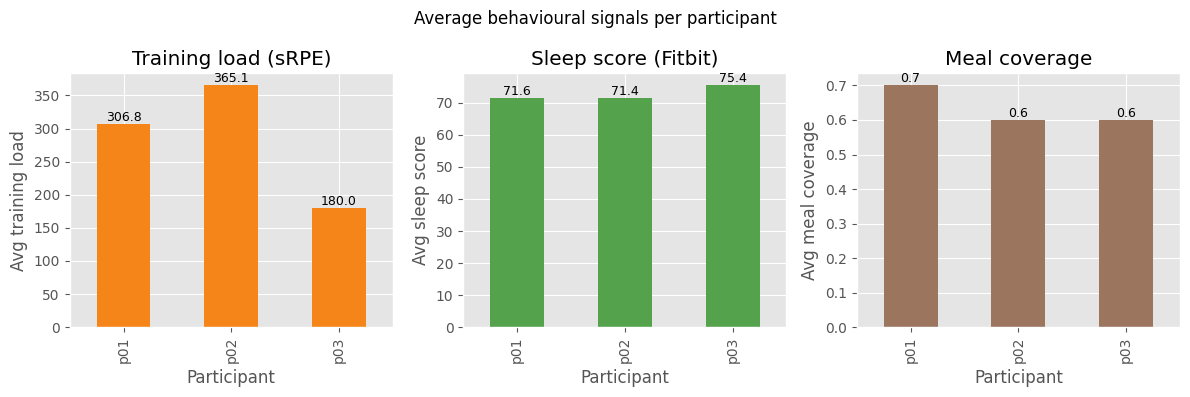

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=False)
metrics = ["avg_training_load", "avg_sleep_score", "avg_meal_coverage"]
titles = ["Training load (sRPE)", "Sleep score (Fitbit)", "Meal coverage"]
colors = ["#f58518", "#54a24b", "#9c755f"]

for ax, metric, title, color in zip(axes, metrics, titles, colors):
    combined_stats[metric].plot(kind="bar", ax=ax, color=color)
    ax.set_title(title)
    ax.set_ylabel(metric.replace("avg_", "Avg ").replace("_", " "))
    ax.set_xlabel("Participant")
    for idx, value in enumerate(combined_stats[metric]):
        ax.text(idx, value, f"{value:0.1f}", ha="center", va="bottom", fontsize=9)

fig.suptitle("Average behavioural signals per participant")
fig.tight_layout()
plt.show()


**Notes:**
- Training load varies substantially across participants, suggesting workload could be a differentiating factor if stress varied enough.
- Sleep scores and meal coverage are relatively stable, implying we may need to engineer additional features (e.g., deviations from personal averages) to reveal stronger patterns.


## Notes and next steps
- **Stress reports** are frequent but mostly fixed at “3”. Collecting the full dataset (16 participants) is the next priority so we can observe higher stress values and strengthen correlations.
- **Supporting data** is rich: subjective readiness/fatigue, device-based sleep metrics, training load, and daily nutrition/hydration. 
- **Feature engineering ideas:** once we addmore data, create lagged predictors (yesterday’s load, sleep, meals) and anomaly indicators (big jumps vs. 7-day baseline) to test which behavioural changes precede elevated stress.
